In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, cross_validate, RandomizedSearchCV, GridSearchCV, learning_curve
)
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
)

from scipy.stats import uniform, randint


In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/stepthom/869_course/refs/heads/main/data/spaceship_titanic_train.csv")

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_sum = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Cabin_Prefix
        X['Cabin_Prefix'] = X['Cabin'].astype(str).str.split('/').str[0]
        # Spend features
        X['TotalSpend'] = X[self.columns_to_sum].sum(axis=1)
        X['LuxurySpend'] = X[['Spa', 'VRDeck']].sum(axis=1)
        X['BasicSpend'] = X[['RoomService', 'FoodCourt']].sum(axis=1)
        return X

# Define feature groups
categorical_features = ['HomePlanet',
                        'Destination', 
                        'VIP', 
                        'CryoSleep', 
                        'Cabin_Prefix'
                       ]
numeric_features = ['Age',
                    'RoomService',
                    'FoodCourt',
                    'ShoppingMall',
                    'Spa',
                    'VRDeck', 
                    'TotalSpend',
                    'LuxurySpend',
                    'BasicSpend'
                   ]

# Pipelines
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('to_str', FunctionTransformer(lambda x: x.astype(str))),  # Convert to string
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical_features),
    ('num', num_pipeline, numeric_features)
])

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_keep):
        self.columns_to_keep = columns_to_keep  

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[:, self.columns_to_keep]  
        
# Final pipeline
full_pipeline = Pipeline([
    ('features', FeatureEngineer()),
    ('preprocess', preprocessor),
    #('select_features', ColumnSelector(columns_to_keep=important_features)),
    ('RFclassifier', RandomForestClassifier(random_state=0,
                                            max_depth=5,
                                            min_samples_leaf=10,
                                            n_estimators=100,
                                           ))
])

In [7]:
X = df.drop(columns=['Transported'])
y = df['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features', FeatureEngineer()),
                ('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('to_str',
                                                                   FunctionTransformer(func=<function <lambda> at 0x14333e9e0>)),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'Destination',
                                                   'VIP', 'CryoSleep',
                                                   'Cabin_Prefix']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'TotalSpend', 'LuxurySpend',
                                                   'BasicSpend'])])),
                ('RFclassifier',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=10,
                                        random_state=0))])

In [8]:
# Feature Importances
importances = full_pipeline.named_steps['RFclassifier'].feature_importances_

feat_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_df.head(10))

feat_df.head(100).plot(kind='barh', x='Feature', y='Importance', title='Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

important_features = feat_df.query("Importance > 0.015")['Feature'].tolist()
print(important_features)
important_feature_indices = [i for i, name in enumerate(all_features) if name in important_features]

NameError: name 'all_features' is not defined

In [105]:
# after selected the features
full_pipeline_selected = Pipeline([
    ('features', FeatureEngineer()),
    ('preprocess', preprocessor),
    ('select_features', ColumnSelector(columns_to_keep=important_feature_indices)),
    ('RFclassifier', RandomForestClassifier(random_state=0,
                                            max_depth=11,
                                            min_samples_leaf=2,
                                            n_estimators=400))
])

full_pipeline_selected.fit(X_train, y_train)

Pipeline(steps=[('features', FeatureEngineer()),
                ('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('to_str',
                                                                   FunctionTransformer(func=<function <lambda> at 0x284a277f0>)),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'Destination',
                                                   'VIP', 'CryoSleep'...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'TotalSpend', 'LuxurySpend',
                                                   'BasicSpend'])])),
                ('select_features',
                 ColumnSelector(columns_to_keep=[0, 1, 11, 13, 20, 24, 25, 26,
                                                 27, 28, 29, 30, 31])),
                ('RFclassifier',
                 RandomForestClassifier(max_depth=11, min_samples_leaf=2,
                                        n_estimators=400, random_state=0))])

In [10]:
scores_train = cross_val_score(full_pipeline_selected, X_train, y_train, cv=5, scoring="f1_macro")
print("Train CV F1 Score = {:.5f}".format(scores_train.mean()))

NameError: name 'full_pipeline_selected' is not defined

In [11]:
# RandomForest Hyperparameter Tuning - GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'RFclassifier__max_depth': [11, 12, 13],
    'RFclassifier__min_samples_leaf': [2, 5, 8],
    'RFclassifier__n_estimators': [400, 500, 600],
}

grid = GridSearchCV(full_pipeline_selected, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best F1:", grid.best_score_)

NameError: name 'full_pipeline_selected' is not defined

In [12]:
# Confusion Matrix
y_pred = full_pipeline_selected.predict(X_test)
print(confusion_matrix(y_test, y_pred))

NameError: name 'full_pipeline_selected' is not defined

In [13]:
print("Train CV F1 Score = {:.5f}".format(scores_train.mean()))
print("Test F1 Score = {:.5f}".format(f1_score(y_test, y_pred)))

NameError: name 'scores_train' is not defined

In [14]:
# Learning Curve - overfit checking
train_sizes, train_scores, test_scores = learning_curve(
    full_pipeline_selected, X_train, y_train,
    cv=5,
    scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(train_sizes, train_scores_mean, label="Training F1")
plt.plot(train_sizes, test_scores_mean, label="Validation F1")
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'full_pipeline_selected' is not defined

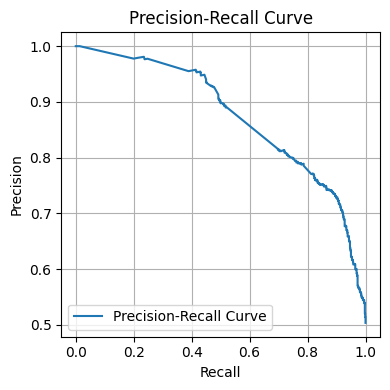

In [110]:
# precision-recall curves

y_scores = full_pipeline_selected.predict_proba(X_test)[:, 1]  
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(4, 4))
plt.plot(recall, precision, label="Precision-Recall Curve") 
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

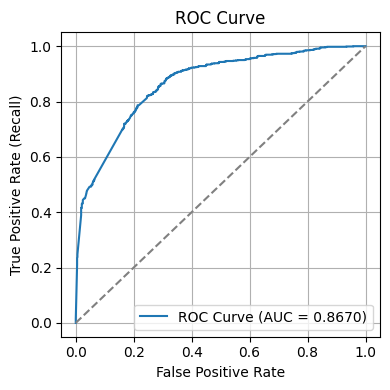

In [111]:
# ROC

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_scores):.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal = random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [112]:
# Performance Metrics
y_pred_cv = (y_scores >= 0.5).astype(int)

results = [{
    'Model': 'Random Forest',
    'F1 Score': f1_score(y_test, y_pred_cv),
    'ROC AUC': roc_auc_score(y_test, y_scores),
    'Precision': precision_score(y_test, y_pred_cv),
    'Recall': recall_score(y_test, y_pred_cv)
}]

# Display results
results_df = pd.DataFrame(results).set_index('Model')
print(results_df.round(4))

               F1 Score  ROC AUC  Precision  Recall
Model                                              
Random Forest    0.7952    0.867     0.7604  0.8333


In [142]:
full_pipeline_selected.fit(X, y) 

Pipeline(steps=[('features', FeatureEngineer()),
                ('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('to_str',
                                                                   FunctionTransformer(func=<function <lambda> at 0x1499f0ee0>)),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'Destination',
                                                   'VIP', 'CryoSleep',
                                                   'Cabin_Prefix']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'TotalSpend', 'LuxurySpend',
                                                   'BasicSpend'])])),
                ('select_features',
                 ColumnSelector(columns_to_keep=[0, 1, 11, 13, 20, 24, 25, 26,
                                                 27, 28, 29, 30, 31])),
                ('RFclassifier',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=10,
                                        random_state=0))])

In [144]:
X_test = pd.read_csv("https://raw.githubusercontent.com/stepthom/869_course/refs/heads/main/data/spaceship_titanic_test.csv")
passengerIDs = X_test["PassengerId"]
pred_comp = full_pipeline_selected.predict(X_test)

# Create a simple dataframe with two columns: the passenger ID (just the same as the test data) and our predictions
my_submission = pd.DataFrame({
    'PassengerId': passengerIDs,
    'Transported': pred_comp})

# Let's take a peak at the results (as a sanity check)
display(my_submission.head(10))

# You could use any filename.
my_submission.to_csv('submission.csv', index=False)

# You can now download the 'submission.csv' from Colab/Kaggle (see menu on the left or right)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True
